# CAT-DOG IMAGE CLASSIFIER

<p><b>Status: <span style=color:orange;>In progress</span></b></p>

##### LOAD IMAGE FILES
Cat : 0 |
Dog : 1

In [1]:
import pandas as pd
import numpy as np
import pickle
import os

data_dir = '../../../data/'
classes = os.listdir(data_dir)  # get classes from folder names

# load feature data
filename = '../../02-data-preprocessing/output/preprocessed_data/X.pckl'
loader = open(filename, 'rb')
X = pickle.load(loader)
loader.close()

# load target data
filename = '../../02-data-preprocessing/output/preprocessed_data/y.pckl'
loader = open(filename, 'rb')
y = pickle.load(loader)
loader.close()

##### SPLIT THE FILE NAMES INTO TRAINING AND TESTING SETS

In [2]:
from sklearn.model_selection import train_test_split

# set the seed for reproducibility
np.random.seed(127)

X = X/255
X = X[:300]
y = y[:300]

# split the dataset into 2 training and 2 testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

print('Data shapes:\n')
print('X_train : {}\ny_train : {}\n\nX_test : {}\ny_test : {}'.format(np.shape(X_train),
                                                                      np.shape(y_train),
                                                                      np.shape(X_test),
                                                                      np.shape(y_test)))

Data shapes:

X_train : (240, 100, 100, 3)
y_train : (240, 2)

X_test : (60, 100, 100, 3)
y_test : (60, 2)


##### DEFINE NETWORK PARAMETERS

In [4]:
# extract images properties
image_width  = np.shape(X_test)[1]
image_height = np.shape(X_test)[2]
n_channels  = np.shape(X_test)[3]
n_classes = y_train.shape[1]
n_features = 3  # dummy

# count number of samples in each set of data
n_train = X_train.shape[0]
n_test = X_test.shape[0]

# define amount of neurons
n_layer_in = n_features  # 11 neurons in input layer
n_layer_h1 = 500          # first   hidden layer
n_layer_h2 = 20          # second  hidden layer
n_layer_out = n_classes  # 7 neurons in input layer

sigma_init = 0.01   # For randomized initialization

##### RESET TENSORFLOW GRAPH IF THERE IS ANY

In [5]:
import tensorflow as tf

# this will set up a specific seed in order to control the output 
# and get more homogeneous results though every model variation
def reset_graph(seed=127):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
reset_graph()

##### MODEL ARCHITECTURE
You can find useful information in the following links:
##### https://ayearofai.com/rohan-lenny-2-convolutional-neural-networks-5f4cd480a60b
##### https://www.guru99.com/convnet-tensorflow-image-classification.html

Convolutional output size:
$$
Conv = \frac{(width-kernel)+(2*Padding)}{stride}+1
$$

Maxpool output size:
$$
MaxPool = \frac{width-kernel}{stride}+1
$$

Padding Value when Padding="SAME":
$$
Padding_{"SAME"} = \frac{width*(stride-1)-stride+kernel}{2}
$$

Number of parameters:
$$
n_{parameters} = ((kernel * channels) + 1) * filters
$$

The general rule is:
By increasing the stride or by using maxpooling, it is possible to reduce the sample, however this will also lose some information. Maxpooling will be more loosely that's why some model nowaday dont use it.


In [6]:
# the basic idea is there is no formula to calculate the optimal stride, kernel, or filter.
# You will have to test them and see how these influence on the results.

# set up some parameters
keep_prob = 0.75

# create symbolic variables
X = tf.placeholder(tf.float32, [None, image_width, image_height, n_channels])
Y = tf.placeholder(tf.float32, [None, n_classes])

with tf.name_scope('cnn'):
    
    x_image = tf.reshape(X, [-1, image_width, image_height, n_channels])
    
    # ------ CONVOLUTIONAL NEURAL NETWORK ------    

    # Convolutional Layer1
    # input shape : batch_size, 100, 100, 3
    # output shape: batch_size, 100, 100, 32
    conv1 = tf.layers.conv2d(inputs=X,
                             filters=32,
                             kernel_size=[5, 5],
                             strides=(1, 1),
                             padding='same',
                             activation=tf.nn.relu)

    # Pooling Layer 1
    # input shape : batch_size, 100, 100, 32
    # output shape: batch_size, 50, 50, 32
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    # Convolutional Layer 2
    # input shape : batch_size, 50, 50, 32
    # output shape: batch_size, 50, 50, 36
    conv2 = tf.layers.conv2d(inputs=pool1,
                             filters=36,
                             kernel_size=[5, 5],
                             strides=(1, 1),
                             padding='same',
                             activation=tf.nn.relu)
    
    # Pooling Layer 2
    # input shape : batch_size, 50, 50, 36
    # output shape: batch_size, 25, 25, 36
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)\
    
    pool2_flat = tf.reshape(pool2, [-1, 25*25*36 ])

    
    # ------ FEED FORWARD NEURAL NETWORK ------
    
    # deploy the variables that will store the weights
    W = {
        'W1': tf.Variable(tf.random_normal([25*25*36, n_layer_h1], stddev = sigma_init), name='W1'),
        'W2': tf.Variable(tf.random_normal([n_layer_h1, n_layer_h2], stddev = sigma_init), name='W2'),
        'W3': tf.Variable(tf.random_normal([n_layer_h2, n_layer_out], stddev = sigma_init), name='W3'),
    }

    # deploy the variables that will store the bias
    b = {
        'b1': tf.Variable(tf.random_normal([n_layer_h1]), name='b1'),
        'b2': tf.Variable(tf.random_normal([n_layer_h2]), name='b2'),
        'b3': tf.Variable(tf.random_normal([n_layer_out]), name='b3'),
    }
    
    with tf.name_scope('hidden_1'):
        layer_h1 = tf.nn.relu(tf.add(tf.matmul(pool2_flat,W['W1']), b['b1']))
        #layer_h1 = tf.nn.dropout(layer_h1, keep_prob)
        
    with tf.name_scope('hidden_2'):
        layer_h2 = tf.nn.relu(tf.add(tf.matmul(layer_h1,W['W2']), b['b2']))
        #layer_h2 = tf.nn.dropout(layer_h2, keep_prob)
        
    with tf.name_scope('layer_output'):
        y_pred = tf.add(tf.matmul(layer_h2,W['W3']), b['b3'])

##### LEARNING RATE CONFIGURATION

In [7]:
learning_rate = 0.05

# CHOOSE A DECAYING METHOD IN HERE
model_decay = 'none'      # [exponential | inverse_time | natural_exponential | polynomial | none]

global_step = tf.Variable(0, trainable=False)
decay_rate = 0.10
decay_step = 10000

if model_decay == 'exponential':
    learning_rate = tf.train.exponential_decay(learning_rate, global_step, decay_step, decay_rate)

elif model_decay == 'inverse_time':
    learning_rate = tf.train.inverse_time_decay(learning_rate, global_step, decay_step, decay_rate)
    
elif model_decay == 'natural_exponential':
    learning_rate = tf.train.natural_exp_decay(learning_rate, global_step, decay_step, decay_rate)
    
elif model_decay == 'polynomial':
    end_learning_rate = 0.001
    learning_rate = tf.train.polynomial_decay(learning_rate, global_step, decay_step, end_learning_rate, power=0.5)
    
else:
    decay_rate = 1.0
    learning_rate = tf.train.exponential_decay(learning_rate, global_step, decay_step, decay_rate)

print('Decaying Learning Rate : ', model_decay)

Decaying Learning Rate :  none


##### OPTIMIZER AND ACCURACY CONFIGURATION

In [8]:
with tf.name_scope('loss'):
    #loss = tf.square(Y - tf.nn.softmax(y_pred))                                        # squared error
    #loss = tf.nn.softmax(logits=y_pred)                                                # softmax
    #loss = tf.nn.log_softmax(logits=y_pred)                                            # log-softmax
    #loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y, logits=y_pred, dim=-1) # cross-entropy
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=Y, logits=y_pred)            # sigmoid-cross-entropy
    #loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=Y, logits=y_pred)     # sparse-softmax-cross-entropy
    
    # compute the average loss
    loss = tf.reduce_mean(loss, name='MSE')
    
with tf.name_scope('train'):
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate)                     # SGD
    #optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,momentum=0.9) # MOMENTUM
    #optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)               # ADAGRAD
    optimizer = tf.train.AdadeltaOptimizer(learning_rate=learning_rate)              # ADADELTA
    #optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate, decay=1)      # RMS
    
    # compute the average loss after each optimization execution
    training_op = optimizer.minimize(loss, global_step=global_step)

with tf.name_scope('eval'):
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))
    

# Create summaries
tf.summary.scalar('loss', loss)
tf.summary.scalar('accuracy', accuracy)
tf.summary.scalar('learn_rate', learning_rate)

# Merge all summaries into a single op to generate the summary data
merged_summary_op = tf.summary.merge_all()

##### DEFINE DIRECTORIES FOR RESULTS

In [9]:
import sys
import shutil
from datetime import datetime

# set up the directory to store the results for tensorboard
now = datetime.utcnow().strftime('%Y%m%d%H%M%S')
root_ckpoint = 'output/tf_checkpoints'
root_logdir = 'output/tf_logs'
logdir = '{}/run-{}/'.format(root_logdir, now) 

## Try to remove tree; if failed show an error using try...except on screen
try:
    shutil.rmtree(root_ckpoint)
except OSError as e:
    print ('Error: %s - %s.' % (e.filename, e.strerror))

Error: output/tf_checkpoints - 系統找不到指定的路徑。.


##### MODEL EXECUTION

In [10]:
# deploy a progress bar
try:
    from tqdm.notebook import tqdm
except ImportError:
    def tqdm(x, *args, **kwargs):
        return x

# define some parameters
n_epochs = 50
display_epoch = 2
batch_size = 5
n_batches = int(n_train/batch_size)

# this will later help me to restore the model to a specific epoch
saver = tf.train.Saver(tf.global_variables())

# store results through every epoch iteration
acc_train_list = []
acc_test_list = []
avg_loss_list = []
learning_list = []


In [11]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    # write logs for tensorboard
    summary_writer = tf.summary.FileWriter(logdir, graph=tf.get_default_graph())
    
    for epoch in tqdm(range(1, n_epochs+1)):
        avg_loss = 0    # accumulate batch average loss for each epoch
        
        for i in range(0, n_train, batch_size):
            # create batches
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]
            
            # start model training
            sess.run(training_op, feed_dict={X:X_batch, Y:y_batch})
            
            # Run optimization (backprop), cost and summary nodes
            _, _loss, _summary = sess.run([training_op, loss, merged_summary_op],
                                          feed_dict={X:X_batch, Y:y_batch})
            avg_loss += _loss/n_batches
            
            # Write logs at every iteration
            summary_writer.add_summary(_summary)
            
        # after the epoch is finished this will append the loss
        avg_loss_list.append(avg_loss)
            
        # measure performance and display the results
        if (epoch+1) % display_epoch == 0:
            _acc_train = accuracy.eval(feed_dict={X: X_train, Y:y_train})
            _acc_test = accuracy.eval(feed_dict={X: X_test, Y: y_test})
            
            # append results to lists
            acc_train_list.append(_acc_train); acc_test_list.append(_acc_test)
            learning_list.append(sess.run(learning_rate))

            # Save model weights to disk for reproducibility
            saver = tf.train.Saver(max_to_keep=15)
            saver.save(sess, '{}/epoch{:04}.ckpt'.format(root_ckpoint, (epoch+1)))
            
            print('Epoch: {:04}\tTrainAcc: {:04.4f}\tTestAcc: {:04.4f}\tLoss: {:04.4f}\tLearning: {:04.4f}'.format((epoch+1),
                                                                                                                   _acc_train,
                                                                                                                   _acc_test,
                                                                                                                   avg_loss,
                                                                                                                   sess.run(learning_rate)))
            
    # store the predicted values
    predictions = sess.run(y_pred, feed_dict={X: X_test, Y: y_test})
    print('\nPrinting network raw output \n\n', predictions)
    predictions = tf.argmax(predictions, 1).eval()
    
    # output comparative table
    dataframe = pd.DataFrame(predictions, columns=['Prediction'])
    dataframe['Target'] = np.argmax(y_test.values, 1)
    dataframe['Hit'] = np.equal(dataframe.Target, dataframe.Prediction)
    print('\n\nPrinting results :\n\n', dataframe)

Epoch: 0002	TrainAcc: 0.5042	TestAcc: 0.5333	Loss: 0.7185	Learning: 0.0500
Epoch: 0004	TrainAcc: 0.5042	TestAcc: 0.5333	Loss: 0.7097	Learning: 0.0500
Epoch: 0006	TrainAcc: 0.5042	TestAcc: 0.5333	Loss: 0.6965	Learning: 0.0500
Epoch: 0008	TrainAcc: 0.5083	TestAcc: 0.6500	Loss: 0.6937	Learning: 0.0500
Epoch: 0010	TrainAcc: 0.5125	TestAcc: 0.5833	Loss: 0.6931	Learning: 0.0500
Epoch: 0012	TrainAcc: 0.5375	TestAcc: 0.6000	Loss: 0.6923	Learning: 0.0500
Epoch: 0014	TrainAcc: 0.5750	TestAcc: 0.6000	Loss: 0.6912	Learning: 0.0500
Epoch: 0016	TrainAcc: 0.5583	TestAcc: 0.5667	Loss: 0.6898	Learning: 0.0500
Epoch: 0018	TrainAcc: 0.5708	TestAcc: 0.5333	Loss: 0.6875	Learning: 0.0500
Epoch: 0020	TrainAcc: 0.5667	TestAcc: 0.5333	Loss: 0.6840	Learning: 0.0500
Epoch: 0022	TrainAcc: 0.5542	TestAcc: 0.5000	Loss: 0.6777	Learning: 0.0500
Epoch: 0024	TrainAcc: 0.5917	TestAcc: 0.5167	Loss: 0.6670	Learning: 0.0500
Epoch: 0026	TrainAcc: 0.6083	TestAcc: 0.5167	Loss: 0.6491	Learning: 0.0500
Epoch: 0028	TrainAcc: 0.6

##### VISUALIZE THE RESULTS

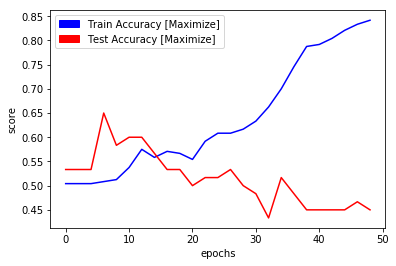

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# set up legend
blue_patch = mpatches.Patch(color='blue', label='Train Accuracy [Maximize]')
red_patch = mpatches.Patch(color='red', label='Test Accuracy [Maximize]')
plt.legend(handles=[blue_patch,red_patch])

# plot the data
x_values = range(0, n_epochs, display_epoch)
plt.plot(x_values, acc_train_list, color='blue')
plt.plot(x_values, acc_test_list, color='red')

plt.xlabel('epochs')
plt.ylabel('score');

##### LEARNING RATE EVOLUTION

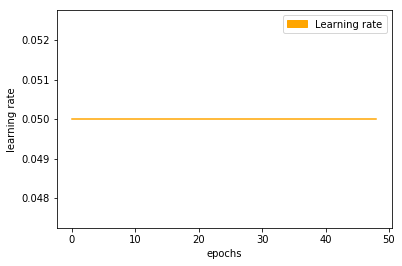

In [13]:
or_patch = mpatches.Patch(color='orange', label='Learning rate')
plt.legend(handles=[or_patch])

plt.plot(x_values, learning_list, color='orange');
plt.xlabel('epochs'.format(display_epoch))
plt.ylabel('learning rate');